# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.22 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
dones = env_info.local_done
rewards = env_info.rewards
next_states = env_info.vector_observations
# Flatten: Generates a pointer with adjusted stride to the data without making new copy
next_states_flat = next_states.flatten()
# Unflatten
next_states_flat = next_states.reshape(num_agents,-1)
print("Dones:",dones)
print("Rewards:",dones)
print("Next States shape:",next_states.shape)
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
Dones: [False, False]
Rewards: [False, False]
Next States shape: (2, 24)
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

## Libraries and General Initialization

In [5]:
# NN Related Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

# Replay Buffer libraries
import random
from collections import namedtuple, deque

# Plotting/Graphing libraries
import matplotlib.pyplot as plt

#Initalization general vars and types
Experience = namedtuple("experience",field_names=["state","action","reward","next_state","done"])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Models/Networks Definition

In [6]:
def hidden_init(layer):
    """Using Kaiming Layer initialization"""
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        fc_units = [256, 128]
        self.fc1 = nn.Linear(state_size, fc_units[0])
        self.fc2 = nn.Linear(fc_units[0], fc_units[1])
        self.out = nn.Linear(fc_units[1], action_size)
        self.bn1 = nn.BatchNorm1d(fc_units[0])
        self.reset_parameters()
        
    def forward(self, state):
        x = F.leaky_relu(self.fc1(state))
        x = self.bn1(x)
        x = F.leaky_relu(self.fc2(x))
        return F.tanh(self.out(x))

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.out.weight.data.uniform_(-3e-3, 3e-3)

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, num_agents, state_size, action_size, seed):
        super(Critic, self).__init__()
        fc_units = [256, 128, 64]
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(num_agents * (state_size+action_size), fc_units[0])
        self.fc2 = nn.Linear(fc_units[0], fc_units[1])
        self.fc3 = nn.Linear(fc_units[1], fc_units[2])
        self.fc4 = nn.Linear(fc_units[2], 1)
        self.bn1 = nn.BatchNorm1d(fc_units[0])
        self.reset_parameters()
        
    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xsa = torch.cat((state, action), dim=1)
        xsa = F.leaky_relu(self.fc1(xsa))
        xsa = self.bn1(xsa)
        x = F.leaky_relu(self.fc2(xsa))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x)

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(*hidden_init(self.fc4))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

## Replay Buffer

In [7]:
class ReplayBuffer():
    def __init__(self, buffer_size, batch_size, seed = 0):
        self.seed_ = random.seed(seed)
        self.batch_size_ = batch_size
        self.memory_ = deque(maxlen=buffer_size)
        
    def sample(self):
        experiences = random.sample(self.memory_, k=self.batch_size_)
        # NOTE: Very important to ensure casting to the right types (otherwise very deadly bug)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def add(self, state, action, reward, next_state, done):
        self.memory_.append(Experience(state, action, reward, next_state, done))

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory_)

## OUNoise

In [8]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.size = size
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

## MADDPG Agent
**Future Work**
1. PER
2. TD-2/TD-3/GAE

In [10]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0.0      # L2 weight decay

N_LEARN_UPDATES = 10     # number of learning updates
N_TIME_STEPS = 20       # every n time step do update

EPSILON_MIN = 0.01
EPSILON_MAX_STEPS = 1e6

class AgentNetwork():
    """ Class to store networks for each agents"""
    def __init__(self, idx, n_agents, state_size, action_size, random_seed):
        self.idx = idx
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        self.epsilon = 1
        self.epsilon_decay = (self.epsilon-EPSILON_MIN)/(EPSILON_MAX_STEPS)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(n_agents, state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(n_agents, state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

class MultiAgent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, n_agents, state_size, action_size, random_seed=0):
        """Initialize an Agent object.
        Params
        ======
            num_agents  (int): number of agent
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.n_agents= n_agents
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.agent_nets = [AgentNetwork(idx, n_agents, state_size, action_size, random_seed=0) for idx in range(num_agents)]        
        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, agent_id, t_step, memory):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # only learn every n_time_steps
        if t_step % N_TIME_STEPS != 0:
            return

        # Learn, if enough samples are available in memory
        if len(memory) > BATCH_SIZE:
            for agent_id in range(self.n_agents):
                for i in range(N_LEARN_UPDATES):
                    self.agent_nets[agent_id].epsilon -= self.agent_nets[agent_id].epsilon_decay
                    experiences = memory.sample()
                    self.learn(agent_id, experiences, GAMMA)

    def act(self, idx, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.agent_nets[idx].actor_local.eval()
        if(self.agent_nets[idx].epsilon < EPSILON_MIN):
            self.agent_nets[idx].epsilon = EPSILON_MIN
        with torch.no_grad():
            action = self.agent_nets[idx].actor_local(state).cpu().data.numpy()
        self.agent_nets[idx].actor_local.train()
        if add_noise:
            action += self.agent_nets[idx].epsilon * self.agent_nets[idx].noise.sample()
        return np.clip(action,-1,1)

    def reset(self):
        for agent_net in self.agent_nets:
                agent_net.noise.reset()

    def learn(self, idx, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        Actor_loss = -critic_local(states, actions_pred).mean()
        Because we want to updated actor S.T it maximize the state value which is the critic_local
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states_flat, actions_flat, rewards_flat, next_states_flat, dones_flat = experiences
#         Check shapes being loaded
#         print("learn states_flat",states_flat.shape)
#         print("learn actions_flat",actions_flat.shape)
#         print("learn rewards_flat",rewards_flat.shape)
#         print("learn next_states_flat",next_states_flat.shape)
#         print("learn dones_flat",dones_flat.shape)
        
        #------------------------- Generate View with original shape -------------------------#         
        states = states_flat.reshape(-1, self.n_agents, self.state_size)
        actions = actions_flat.reshape(-1, self.n_agents, self.action_size)
        rewards_cur_agent = rewards_flat[:,idx].reshape(-1,1) #Picked out rewards for current agent
        next_states = next_states_flat.reshape(-1, self.n_agents, self.state_size)
        dones_cur_agent = dones_flat[:,idx].reshape(-1,1) # Picked out dones for current agent
    
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        Q_prediction = self.agent_nets[idx].critic_local(states_flat, actions_flat)
        # Stack all agent's actor output.
        next_actions = ()
        actions_pred = ()
        for cur_id in range(self.n_agents):
            if(cur_id == idx):
                next_actions += (self.agent_nets[cur_id].actor_target(next_states[:,cur_id,:]),)
                actions_pred += (self.agent_nets[cur_id].actor_local(states[:,cur_id,:]),)
            else:
                with torch.no_grad():
                    next_actions += (self.agent_nets[cur_id].actor_target(next_states[:,cur_id,:]),)
                    actions_pred += (self.agent_nets[cur_id].actor_local(states[:,cur_id,:]),)

        next_actions_flat = torch.cat(next_actions, dim=1)
        Q_label_next = self.agent_nets[idx].critic_target(next_states_flat, next_actions_flat)
        Q_label = rewards_cur_agent + (gamma * Q_label_next * (1-dones_cur_agent))
        
        # Update Critic Network
        critic_loss = F.mse_loss(Q_prediction, Q_label.detach())
        self.agent_nets[idx].critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.agent_nets[idx].critic_local.parameters(), 1)
        self.agent_nets[idx].critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred_flat = torch.cat(actions_pred, dim=1)
        actor_loss = -self.agent_nets[idx].critic_local(states_flat, actions_pred_flat).mean()
        self.agent_nets[idx].actor_optimizer.zero_grad()
        actor_loss.backward()
        self.agent_nets[idx].actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.agent_nets[idx].critic_local, self.agent_nets[idx].critic_target, TAU)
        self.soft_update(self.agent_nets[idx].actor_local, self.agent_nets[idx].actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## MADDPG Training Loop

Episode 100	Average Score: 0.00450	Score: 0.045000
Episode 200	Average Score: -0.00300	Score: -0.00500
Episode 300	Average Score: -0.00200	Score: -0.00500
Episode 400	Average Score: -0.00450	Score: -0.00500
Episode 500	Average Score: -0.00100	Score: -0.00500
Episode 600	Average Score: 0.01900	Score: 0.0450000
Episode 700	Average Score: 0.02700	Score: -0.00500
Episode 800	Average Score: 0.02395	Score: 0.045000
Episode 900	Average Score: 0.04350	Score: -0.00500
Episode 1000	Average Score: 0.06300	Score: 0.09500
Episode 1100	Average Score: 0.07050	Score: 0.045000
Episode 1200	Average Score: 0.06800	Score: 0.095000
Episode 1300	Average Score: 0.10990	Score: 0.045000
Episode 1400	Average Score: 0.19800	Score: 0.145000
Episode 1500	Average Score: 0.17350	Score: -0.00500
Episode 1600	Average Score: 0.23200	Score: 1.045000
Episode 1700	Average Score: 0.28545	Score: 0.095000
Episode 1800	Average Score: 0.26300	Score: 0.095000
Episode 1900	Average Score: 0.31400	Score: 0.245000
Episode 2000	Aver

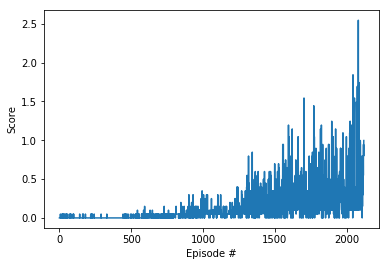

In [11]:
def maddpg(n_episodes=10000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    moving_average = []
    agents = MultiAgent(num_agents, state_size, action_size)
    multi_memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed=0)
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        score = np.zeros(num_agents)
        agents.reset()
        actions = np.random.randn(num_agents, action_size)
        for t in range(max_t):
            actions = np.vstack([agents.act(agent_id, states[agent_id,:].reshape(1,-1)) for agent_id in range(num_agents)])
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations   # get the next state
            rewards = np.array(env_info.rewards)                   # get the reward
            dones = np.array(env_info.local_done)                  # see if episode has finished
            # Check shapes being stored      
#             print("states loop shape:", states.flatten().shape)
#             print("action states shape:", actions.flatten().shape)
#             print("rewards shape:", rewards.shape)
#             print("next states shape:", next_states.flatten().shape)
#             print("dones shape:", dones.shape)
            multi_memory.add(states.flatten(), actions.flatten(), rewards, next_states.flatten(), dones)
            for agent_id in range(num_agents):
                agents.step(agent_id, t, multi_memory)
            states = next_states
            score += rewards
            if any(dones):
                break 
        avg_score = np.mean(score)
        scores_deque.append(avg_score)
        scores.append(avg_score)
        avg_deque_score = np.mean(scores_deque)
        moving_average.append(avg_deque_score)
        print('\rEpisode {}\tAverage Score: {:.5f}\tScore: {:.5f}'.format(i_episode, np.mean(scores_deque), scores[-1]), end="")
        if i_episode % 100 == 0:
            for i, agent in enumerate(agents.agent_nets):
                torch.save(agent.actor_local.state_dict(), "checkpoint_actor_"+str(i)+".pth")
                torch.save(agent.critic_local.state_dict(), "checkpoint_critic_"+str(i)+".pth")
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if avg_deque_score > 0.51:
            for i, agent in enumerate(agents.agent_nets):
                torch.save(agent.actor_local.state_dict(), "checkpoint_actor_"+str(i)+".pth")
                torch.save(agent.critic_local.state_dict(), "checkpoint_critic_"+str(i)+".pth")
            print('\r Solved within Episode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
            break

    return scores, moving_average

scores, moving_average = maddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

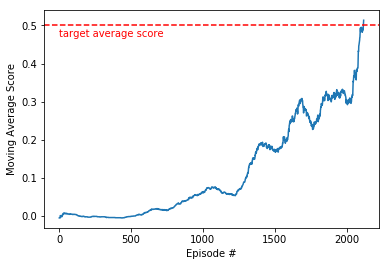

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), moving_average)
plt.ylabel('Moving Average Score')
plt.xlabel('Episode #')
plt.axhline(y=0.5, color='r', linestyle='--')
plt.text(0.5,0.47,'target average score', color='r')
plt.show()